### Simple lasagne GAN on NotMnist

NotMnist is is  blah,
we do blah blah.

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/gumbel_lstm/master/gumbel_sigmoid.py -O gumbel_sigmoid.py

--2017-01-07 07:29:30--  https://raw.githubusercontent.com/yandexdataschool/gumbel_lstm/master/gumbel_sigmoid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4138 (4.0K) [text/plain]
Saving to: ‘gumbel_sigmoid.py’

100%[======================================>] 4,138       --.-K/s   in 0s      

2017-01-07 07:29:30 (59.7 MB/s) - ‘gumbel_sigmoid.py’ saved [4138/4138]



In [2]:
#get dataset

#notmnist small
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
!tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log

--2017-01-07 07:29:30--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8458043 (8.1M) [application/x-gzip]
Saving to: ‘notMNIST_small.tar.gz.4’

100%[======================================>] 8,458,043   2.31MB/s   in 3.5s   

2017-01-07 07:29:34 (2.31 MB/s) - ‘notMNIST_small.tar.gz.4’ saved [8458043/8458043]



In [135]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np
IMG_SHAPE = (28,28)

In [136]:
%env THEANO_FLAGS="device=gpu7"

import theano
from gumbel_sigmoid import GumbelSigmoid

tau = theano.shared(np.float32(0.2), name="gumbel_temp")
x = theano.tensor.tensor4(dtype="float32")


gumb = theano.function([x], GumbelSigmoid(t=tau)(x))

env: THEANO_FLAGS="device=gpu7"


In [137]:
from scipy.misc import imread,imresize
from glob import glob

data = []
for path in glob('./notMNIST_small/*/*'):
    try:
        data.append(imresize(imread(path),IMG_SHAPE))
    except:
        print "fuckup:",path
        
data = np.stack(data)[:,None]
data = data.astype(np.float32)

#now we make pixels to have a value of 0 or 1
data /= 256
data = data.round()

data-=0.5

data*= 10

#data = gumb(data)


fuckup: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
fuckup: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


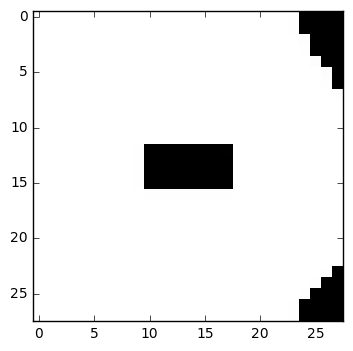

In [138]:
plt.imshow(data[np.random.randint(data.shape[0]),0], cmap="gray", interpolation="none")

-----

In [139]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from lasagne.regularization import regularize_layer_params, l2
from lasagne.nonlinearities import leaky_rectify, linear, sigmoid, rectify
from lasagne.init import Normal #scince bad init can blow the network up =c
theano.config.floatX = 'float32'

In [140]:


inputZ = T.matrix('input_noise', 'float32')
inputX = T.tensor4('input_img', 'float32') # [batch_size, num_channels, height, width]

CODE_SIZE = 128 # size of uniform noise

class generator:
    l_in = InputLayer((None, CODE_SIZE), input_var=inputZ, name='g_input')

    l_dense0 = DenseLayer(l_in,20*8*8,nonlinearity=T.tanh)
    
    l_reshape = ReshapeLayer(l_dense0, (-1, 20, 8, 8), name='dense_reshaped')
    
    l_deconv0 = Deconv2DLayer(l_reshape, 64, 5, nonlinearity=T.tanh, name='g_deconv0')
    
    l_upscale = Upscale2DLayer(l_deconv0, 2)
    
    l_deconv1 = Deconv2DLayer(l_upscale, 100, 3, nonlinearity=T.tanh, name='g_deconv1')
    
    l_deconv2 = Deconv2DLayer(l_deconv1, 100, 3, nonlinearity=T.tanh, name='g_deconv2')
    
    #l_downscale_conv = Conv2DLayer(l_deconv2, 32, 3, nonlinearity=rectify, name='g_downscale_conv')
    #l_gen = Deconv2DLayer(l_downscale_conv, 1, 3, nonlinearity=None, name='g_deconv_out')
    l_deconv3 = Deconv2DLayer(l_deconv2, 64, 3, nonlinearity=sigmoid, name='g_deconv3')
    l_gen = Conv2DLayer(l_deconv3, 1, 3, nonlinearity=GumbelSigmoid(tau), name='g_deconv_out')
    
    print l_gen.output_shape
    #l_gen = Conv2DLayer(l_deconv, 1, 1, nonlinearity=linear, name='g_gen_conv')
    
    assert len(l_gen.output_shape)==4 and l_gen.output_shape[1:] == (1,)+IMG_SHAPE    
    weights = get_all_params(l_gen, trainable=True)
    
    sample = theano.function([inputZ],get_output(l_gen))
    
    
class discriminator:
    l_in = InputLayer((None, 1, IMG_SHAPE[0], IMG_SHAPE[1]),W = Normal(1e-5), name='d_input')
    l_conv0 = Conv2DLayer(l_in, 32, 5, nonlinearity=T.tanh)
    l_pooling0 = Pool2DLayer(l_conv0, 3)
    l_conv1 = Conv2DLayer(l_pooling0, 32, 5, nonlinearity=T.tanh)
    l_dense0 = DenseLayer(l_conv1, 32,nonlinearity=T.tanh)
    
    
    l_prob = DenseLayer(l_dense0,1,W = Normal(1e-5),nonlinearity=sigmoid) #P(real|x)
    
    l_prob_regularization = regularize_layer_params(l_prob, l2)*1e-4
    
    
    weights = get_all_params(l_prob, trainable=True)
    
    predict = theano.function([inputX],get_output(l_prob,inputX))
    
class training:
    
    #D(data)
    p_real_is_real = get_output(discriminator.l_prob, inputs=GumbelSigmoid(t=tau)(inputX))
    
    #D(G(z))
    generated_img = get_output(generator.l_gen)
    p_gen_is_real = get_output(discriminator.l_prob, generated_img)
    
    ########################
    ###generator training###
    ########################
    
    g_loss = -T.log(p_gen_is_real).mean()
    g_updates = lasagne.updates.adagrad(g_loss, generator.weights, 0.01)
    g_train_step = theano.function([inputZ], g_loss, updates=g_updates, allow_input_downcast=True)

    
    ########################
    #discriminator training#
    ########################
    d_loss = -(T.log(p_real_is_real) + T.log(1-p_gen_is_real)).mean() + discriminator.l_prob_regularization

    d_updates = lasagne.updates.adagrad(d_loss, discriminator.weights, 0.01)
    d_train_step = theano.function([inputX, inputZ], d_loss, updates=d_updates, allow_input_downcast=True)
    

(None, 1, 28, 28)


In [8]:
from agentnet.utils.persistence import load

In [9]:
#load(generator.l_gen, "notMNIST_generator.net")
#load(discriminator.l_prob,"notMNIST_discriminator.net")

### Auxilary functions
Sampling, visualization

In [141]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.sample(sample_noise_batch(bsize=nrow*ncol))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),label='D(x)', alpha=0.5)
    plt.hist(discriminator.predict(generator.sample(sample_noise_batch(bsize))),label='D(G(z))',alpha=0.5)
    plt.legend(loc='best')
    plt.xlim(0,1)
    plt.show()

### Training

0.902303993702 0.41473454237


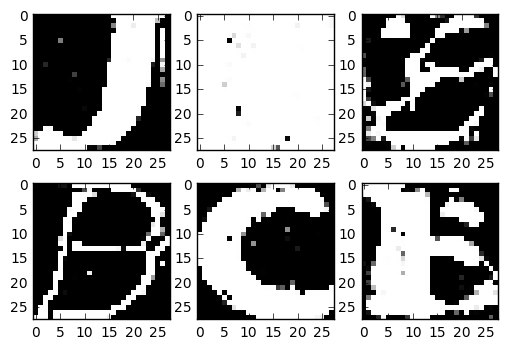

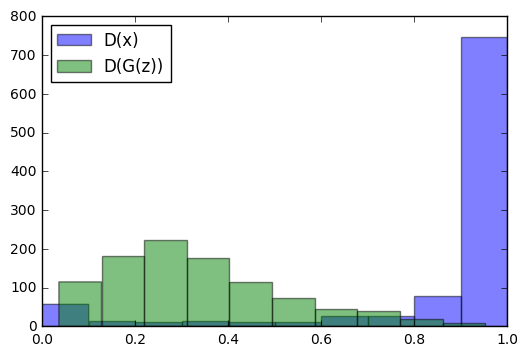

 11%|█         | 11065/100000 [17:22<2:18:00, 10.74it/s]


KeyboardInterrupt: 

In [157]:
from IPython import display
from tqdm import tqdm


tau.set_value(1.0)
for epoch in tqdm(range(100000)):
    for i in range(1):
        training.d_train_step(sample_data_batch(100), sample_noise_batch(100))
    for i in range(2):
        training.g_train_step(sample_noise_batch(100))
    tau.set_value((tau.get_value()*(1-0.00008)).astype("float32"))
    if epoch %1000==0:
        display.clear_output(wait=True)
        print(training.d_train_step(sample_data_batch(100), sample_noise_batch(100))), tau.get_value()
        sample_images(2,3,True)
        sample_probas(1000)
        

In [ ]:
training.g_train_step(sample_noise_batch(100))

In [8]:
from agentnet.utils.persistence import save

In [9]:
#save(generator.l_gen, "notMNIST_generator.net")
#save(discriminator.l_prob,"notMNIST_discriminator.net")

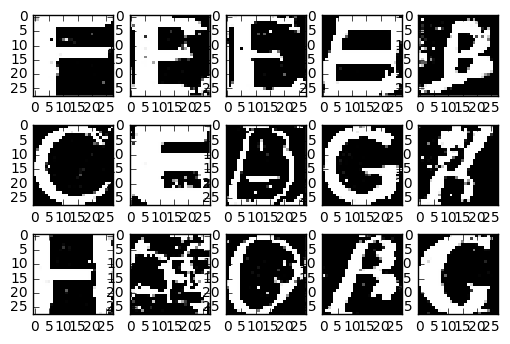

In [174]:
sample_images(3,5,True)

>
